In [ ]:
!rm -rf cv-image-classification
!git clone https://github.com/AlexFerroni02/cv-image-classification.git

Cloning into 'cv-image-classification'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 8), reused 24 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 2.12 MiB | 40.29 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
import sys
sys.path.append("/content/cv-image-classification")

# Data Augmentation & Regularization

Based on the previous error analysis, the baseline model struggles with:
- Object scale variations
- Background dominance
- Limited invariance to transformations

In this notebook, we introduce data augmentation and regularization
to improve generalization without increasing model complexity.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
import sys
sys.path.append("/content/cv-image-classification")

In [ ]:
# Training-time DATA AUGUMENTATION
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # Handles left-right invariance
    transforms.RandomCrop(32, padding=4),     # Improves robustness to scale/position
    transforms.ToTensor()
])

# No augmentation for test set
test_transform = transforms.ToTensor()


Data augmentation artificially increases dataset diversity.
This helps the model learn invariant features instead of memorizing patterns.


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [ ]:

from src.model import RegularizedCNN
model = RegularizedCNN(num_classes=10).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4  # L2 regularization
)


Weight decay penalizes large weights, improving generalization.
Dropout reduces co-adaptation between neurons.


In [ ]:
# Train LOOP
from src.training import train_one_epoch, evaluate
num_epochs = 25

train_accs, test_accs = [], []
test_losses,train_losses, = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(
        model, test_loader, criterion, device
    )
    train_losses.append(train_loss)

    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )

Epoch [1/25] Train Loss: 1.7500, Train Acc: 0.3427 | Test Loss: 1.5663, Test Acc: 0.4044
Epoch [2/25] Train Loss: 1.5481, Train Acc: 0.4226 | Test Loss: 1.2549, Test Acc: 0.5541
Epoch [3/25] Train Loss: 1.4648, Train Acc: 0.4574 | Test Loss: 1.2682, Test Acc: 0.5534
Epoch [4/25] Train Loss: 1.4192, Train Acc: 0.4779 | Test Loss: 1.1843, Test Acc: 0.5733
Epoch [5/25] Train Loss: 1.3830, Train Acc: 0.4937 | Test Loss: 1.1732, Test Acc: 0.5889
Epoch [6/25] Train Loss: 1.3509, Train Acc: 0.5056 | Test Loss: 1.0937, Test Acc: 0.6181
Epoch [7/25] Train Loss: 1.3257, Train Acc: 0.5168 | Test Loss: 1.1345, Test Acc: 0.5861
Epoch [8/25] Train Loss: 1.3091, Train Acc: 0.5272 | Test Loss: 1.1183, Test Acc: 0.5981
Epoch [9/25] Train Loss: 1.2708, Train Acc: 0.5379 | Test Loss: 0.9601, Test Acc: 0.6713
Epoch [10/25] Train Loss: 1.2549, Train Acc: 0.5456 | Test Loss: 0.9665, Test Acc: 0.6630
Epoch [11/25] Train Loss: 1.2346, Train Acc: 0.5553 | Test Loss: 0.9803, Test Acc: 0.6493
Epoch [12/25] Train

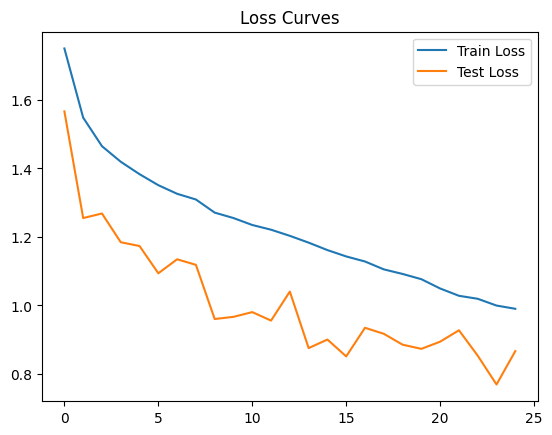

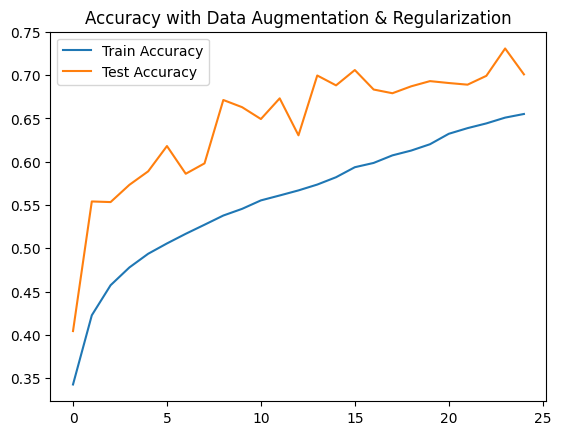

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()



plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.title("Accuracy with Data Augmentation & Regularization")
plt.show()


## Comparison with Baseline

Compared to the baseline model:
- Training accuracy increases more slowly
- Test accuracy improves steadily
- Overfitting is significantly reduced

This behavior indicates better generalization rather than memorization.


## Conclusions

Data augmentation and regularization significantly improve the model's
ability to generalize to unseen data.

The improvements are achieved without increasing architectural complexity,
demonstrating the importance of training strategy over model size.

This model represents a stronger and more realistic baseline for
real-world computer vision tasks.


In [ ]:
model_save_path = "regularized_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Modello salvato su: {model_save_path}")

Modello salvato su: trained_model_with_augmentation.pth
